In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import orbipy as op

In [2]:
model = op.crtbp3_model('Earth-Moon (default)')
plotter = op.plotter.from_model(model, length_units='Mm')
scaler = op.scaler.from_model(model)

In [3]:
halo = pd.read_csv("halo_general_upper.csv")

In [4]:
def NextDxNewton(dx, y0, y1, dxmax, tol):
    NewDx = 0
    if abs(y1)>=tol and y0 != y1:
        NewDx = dx
        if y1 != 0:  
            NewDx = max(min(dx * y1/(y0-y1),dxmax),-dxmax)

    return NewDx

class optimizer:
    dx = 0.001
    dxmax = 0.1
    xvals = []
    yvals = []
    step = 0
    tolerance = 0.000001

    def __init__(self):
        self.xvals = []
        self.yvals = []
        self.step = 0
        
    def needNextStep(self):
        if len(self.yvals) <= 2: return True
        if abs(self.xvals[0]-self.xvals[1]) <= self.tolerance:
            return False
        else:
            return True
            
            
    def nextX(self, x, y):
        self.step+=1;
        
        i = 0
        #находим место для добавления точки, чтобы массив остался отсортированным
        while i < min(2, len(self.yvals)) and y > self.yvals[i]: i+=1
        self.xvals.insert(i,x)
        self.yvals.insert(i,y)

        xvals = self.xvals
        yvals = self.yvals
        
        if self.step == 1:
            return x+self.dx

        x1 = xvals[0]+NextDxNewton(xvals[1]-xvals[0], yvals[0], yvals[1], self.dx, 0)
        if self.step > 2:
            #print(xvals, yvals)
            a = yvals[0]/(xvals[0]-xvals[1])/(xvals[0]-xvals[2]) - yvals[1]/(xvals[0]-xvals[1])/(xvals[1]-xvals[2]) + yvals[2]/(xvals[1]-xvals[2])/(xvals[0]-xvals[2])
            #print(a)
            if a > 0:
                b = (yvals[0]-yvals[1])/(xvals[0]-xvals[1]) - a*(xvals[0]+xvals[1])
                xm = -b/2/a
                x1 = x + max(min(xm-x, self.dxmax), -self.dxmax)
        
        return x1

    def getXY(self):
        return (self.xvals[0], self.yvals[0])


# Расчет семейства

In [15]:
values0 = []

x = 0.8427652545501697 
z = 0.16443739803211613
v = 0.26632324269927443
d = 0
alpha0 = 59 * np.pi / 180

values0.append((x, z, v, alpha0, d, 0))

In [16]:
radius = 150 / model.R

ref 0 [0.84575409 0.         0.16946611 0.         0.25272943 0.        ]
Distance 7.666749613152518e-14
Angle 1.051409247626615
ref 1 [0.84594778 0.         0.16980487 0.         0.2519718  0.        ]
Distance 1.008365450740916e-13
Angle 1.0520249222150884
ref 2 [0.84614125 0.         0.17014375 0.         0.25121543 0.        ]
Distance 1.2932836318273352e-13
Angle 1.0526371478357521


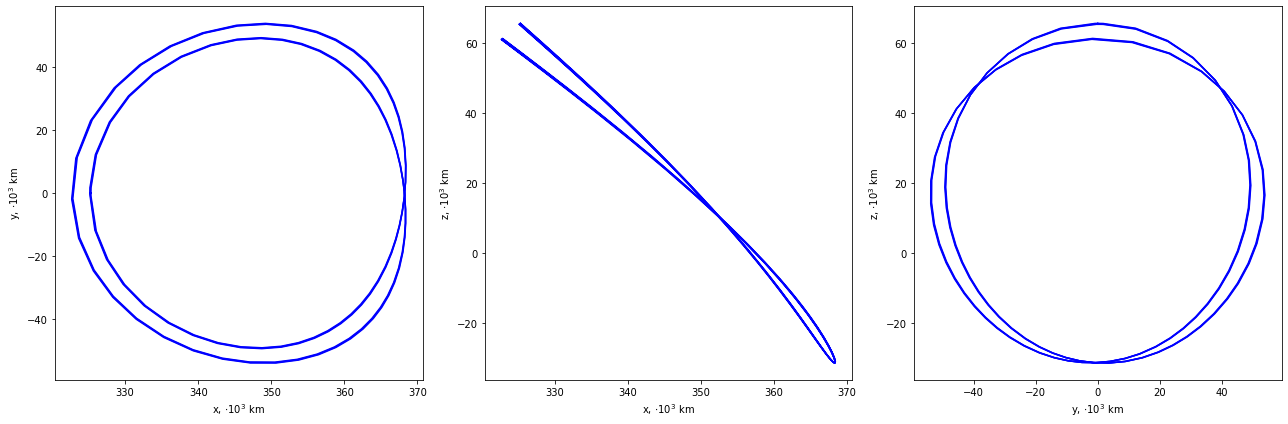

In [26]:
fig, ax = plt.subplots(1, 3, figsize = (18,6))
det_y = op.event_detector(model, events=[op.eventY(count=4)])

x, z, v, alpha0 = values0[-1][:-2]

for n in range(3):
    v1 = v
    ref = model.get_zero_state()
    ref[0], ref[2], ref[4] = x, z, v
    arr, ev = det_y.prop(ref, 0., 20.*np.pi, last_state='last')
    print('ref', n, ref)
    
    opt0 = optimizer()
    opt0.dx = 0.05
    opt0.dxmax = 0.1
    opt0.tolerance = 1e-14
    
    distvals = np.array([100, v])
    
    for k in range(10):
        if opt0.needNextStep() == False: break
    
        x1 = x + radius * np.cos(alpha0)
        z1 = z + radius * np.sin(alpha0)
        
        cur = model.get_zero_state()
        cur[0], cur[2], cur[4] = x1, z1, v1
        dv = 5e-4

        for i in range(8):  
            opt = optimizer()
            opt.dx = 1e-2
            opt.dxmax = 1e-1
            opt.tolerance = 1e-10
            
            opt.dx /= 10 ** (i)
            opt.dxmax /= 10 ** (i)

            for j in range(150):
                if opt.needNextStep() == False: break

                det_yi = op.event_detector(model, events=[op.eventY(count=i+1)])
                arr, ev1 = det_yi.prop(cur, 0., 20.*np.pi, last_state='last')
                dist = np.linalg.norm(ev1.iloc[-1, 4:7] - ev.iloc[i%4, 4:7])**2

                v1 = opt.nextX(v1, dist)
                cur[4] = v1
            v1, dist = opt.getXY()
            cur[4] = v1

        det_y1 = op.event_detector(model, events=[op.eventY(count=4)])
        arr1, ev1 = det_y1.prop(cur, 0., 20.*np.pi, last_state='last')
        d22 = np.linalg.norm(cur[:3] - ev1.iloc[-1, 4:7])**2
        if d22 < distvals[0]:
            distvals[0] = d22
            distvals[1] = v1
        alpha0 = opt0.nextX(alpha0, d22)
    
    alpha0, d22 = opt0.getXY()
    
    x += radius * np.cos(alpha0)
    z += radius * np.sin(alpha0)
    v = distvals[1]
    
    ref2 = model.get_zero_state()
    ref2[0], ref2[2], ref2[4] = x, z, v
    
    det_y1 = op.event_detector(model, events=[op.eventY(count=4)])
    arr1, ev1 = det_y1.prop(ref2, 0., 20.*np.pi, last_state='last')
    t = ev1.iloc[-1, 3] / np.pi    
    
    values0.append((x, z, v, alpha0, d22, t))
    print("Distance", d22)
    print("Angle", alpha0)
    plotter.plot_proj(arr1, ax=ax);
    np.savetxt("2pu_r100_3.txt", values0)

In [22]:
vals2 = np.array(values0)

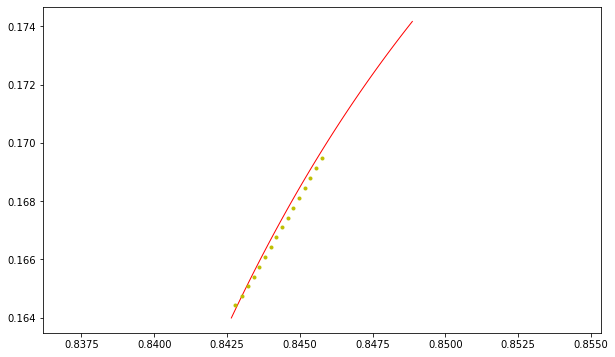

In [27]:
fig, ax = plt.subplots(figsize = (10,6))
ax.axis('equal')
ax.plot(halo.x[600:656], halo.z[600:656], '-r', lw=1)
ax.plot(vals2[:, 0], vals2[:, 1], '.y')

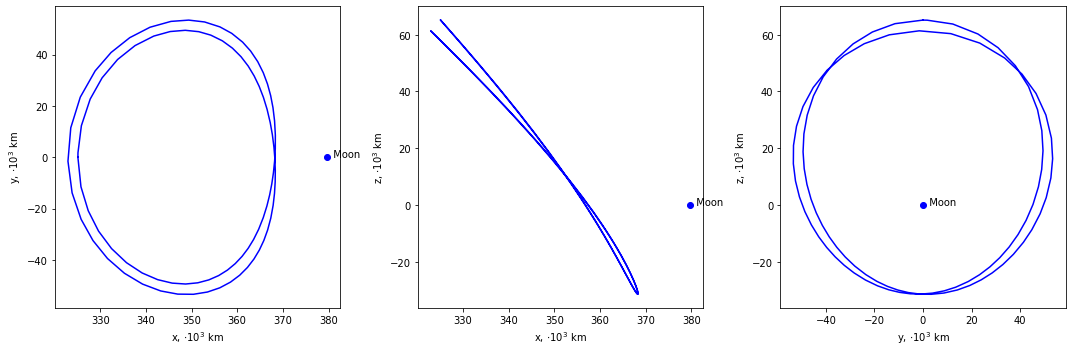

In [28]:
ref = model.get_zero_state()
ref[0], ref[2], ref[4] = vals2[-1, :3]
det_y = op.event_detector(model, events=[op.eventY(count=4)])
arr, ev = det_y.prop(ref, 0., 20.*np.pi, last_state='last')
ax = plotter.plot_proj(arr);
plotter.plot_proj(plottables=[plotter.m], ax=ax, marker='o');

# Плоскость xy

In [29]:
# где я остановилась
vals2[-1]

array([8.45754091e-01, 1.69466114e-01, 2.52729428e-01, 1.05079328e+00,
       5.65271257e-14, 1.69696714e+00])

In [30]:
values1 = []
x, z, v, alpha0, d22, t = vals2[-1]
values1.append((x, z, v, alpha0, d, 0))

In [31]:
radius = 150 / model.R

ref 0 [0.84575409 0.         0.16946611 0.         0.25272943 0.        ]
Distance 3.019949882155907e-13
Angle 1.0532696170397335

ref 1 [0.84594714 0.         0.16980523 0.         0.25199567 0.        ]
Distance 3.78732470823195e-13
Angle 1.0520181917303428

ref 2 [0.84614062 0.         0.17014411 0.         0.25123942 0.        ]
Distance 4.5110839898279657e-13
Angle 1.0525793680521378



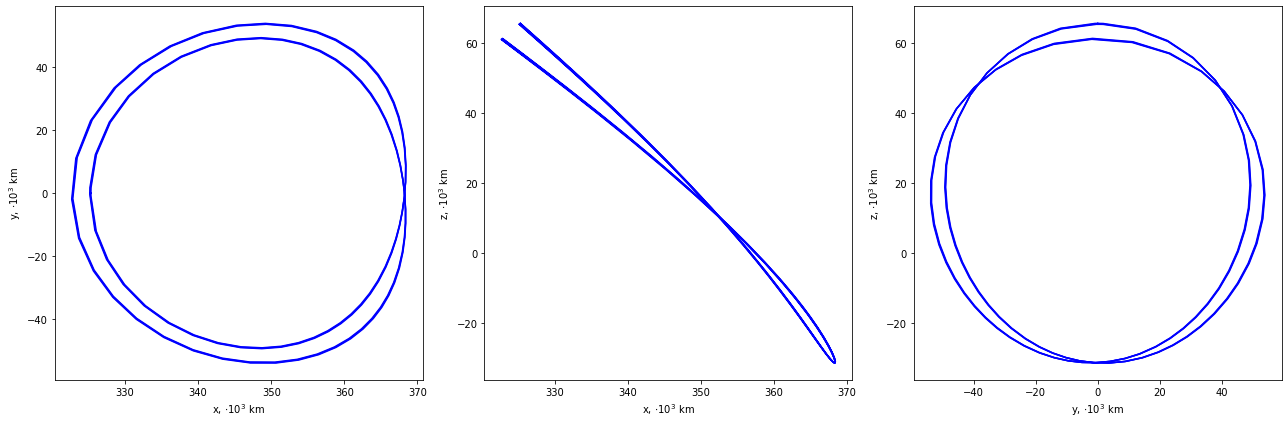

In [32]:
fig, ax = plt.subplots(1, 3, figsize = (18,6))
det_y = op.event_detector(model, events=[op.eventY(count=4)])
det_yz = op.event_detector(model, events=[op.eventZ(count=5, terminal=False), 
                                          op.eventY(count=4)])

x, z, v, alpha0 = values1[-1][:-2]

for n in range(3):
    v1 = v
    ref = model.get_zero_state()
    ref[0], ref[2], ref[4] = x, z, v
    arr, ev = det_yz.prop(ref, 0., 20.*np.pi, last_state='last')
    zpoints = ev[ev.e==0]
    print('ref', n, ref)
    
    opt0 = optimizer()
    opt0.dx = 0.005
    opt0.dxmax = 0.01
    opt0.tolerance = 1e-10
    
    distvals = np.array([100, v])
    
    for k in range(15):
        if opt0.needNextStep() == False: break
    
        x1 = x + radius * np.cos(alpha0)
        z1 = z + radius * np.sin(alpha0)
        
        cur = model.get_zero_state()
        cur[0], cur[2], cur[4] = x1, z1, v1

        for i in range(8):
            opt = optimizer()
            opt.dx = 1e-2
            opt.dxmax = 1e-1
            opt.tolerance = 1e-10
            
            opt.dx /= 10 ** (i)
            opt.dxmax /= 10 ** (i)
            
            for j in range(100):
                if opt.needNextStep() == False: break

                det_zi = op.event_detector(model, events=[op.eventZ(count=i+1)])
                arr, ev1 = det_zi.prop(cur, 0., 20.*np.pi, last_state='last')
                dist = np.linalg.norm(ev1.iloc[-1, 4:7] - zpoints.iloc[i%4, 4:7])**2

                v1 = opt.nextX(v1, dist)
                cur[4] = v1
            v1, dist = opt.getXY()
            cur[4] = v1

        det_y1 = op.event_detector(model, events=[op.eventY(count=4)])
        arr1, ev1 = det_y1.prop(cur, 0., 20.*np.pi, last_state='last')
        d22 = np.linalg.norm(cur[:3] - ev1.iloc[-1, 4:7])**2
        if d22 < distvals[0]:
            distvals[0] = d22
            distvals[1] = v1
        alpha0 = opt0.nextX(alpha0, d22)
    alpha0, d22 = opt0.getXY()
    
    x += radius * np.cos(alpha0)
    z += radius * np.sin(alpha0)
    v = distvals[1]
    
    ref2 = model.get_zero_state()
    ref2[0], ref2[2], ref2[4] = x, z, v
    
    det_y1 = op.event_detector(model, events=[op.eventY(count=4)])
    arr1, ev1 = det_y1.prop(ref2, 0., 20.*np.pi, last_state='last')
    t = ev1.iloc[-1, 3] / np.pi    
    
    values1.append((x, z, v, alpha0, d22, t))
    print("Distance", d22)
    print("Angle", alpha0)
    print()
    plotter.plot_proj(arr1, ax=ax);
    #np.savetxt("2pu_r100_4.txt", values1)

In [33]:
vals3 = np.array(values1)

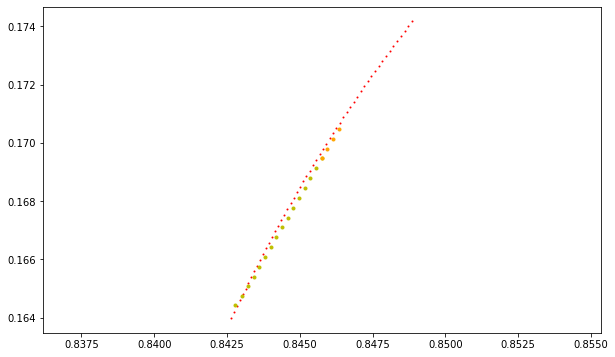

In [37]:
fig, ax = plt.subplots(figsize = (10,6))
ax.axis('equal')
ax.plot(halo.x[600:656], halo.z[600:656], '.r', ms=2)
ax.plot(vals2[:, 0], vals2[:, 1], '.y')
ax.plot(vals3[:, 0], vals3[:, 1], '.', color='orange')

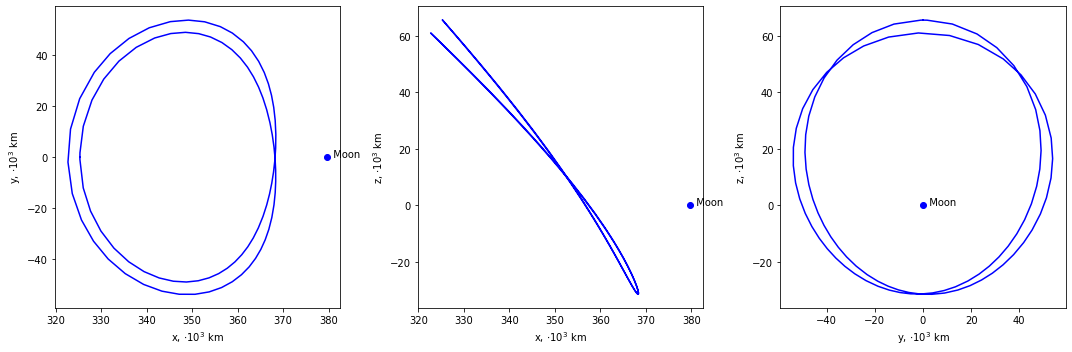

In [40]:
ref = model.get_zero_state()
ref[0], ref[2], ref[4] = vals3[-1, :3]#vals3[-450, :3]
det_y = op.event_detector(model, events=[op.eventY(count=4)])
arr, ev = det_y.prop(ref, 0., 20.*np.pi, last_state='last')
ax = plotter.plot_proj(arr);
plotter.plot_proj(plottables=[plotter.m], ax=ax, marker='o');